In [1]:
%matplotlib inline
import math
import os

import IPython.display
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats.stats as stats

In [2]:
sns.set_context('paper')
sns.set_style('whitegrid')

In [3]:
# read and preprocess the temperature data
temperature = pd.read_csv('../data/iMonDB_Door_Temperature.txt', sep='\t', header=0,
                          parse_dates={'Timestamp': [0]}, index_col='Timestamp')

# make sure that all times are rounded to the nearest quarter of an hour
temperature.index = temperature.index.round('15min')
# smooth out the measurements using an 8 hour rolling window
temperature = temperature.rolling('8h').mean()

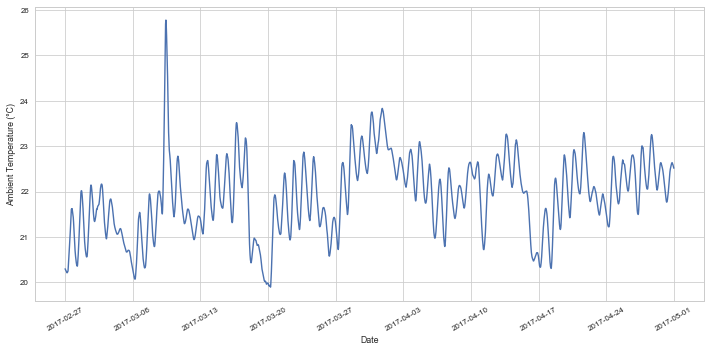

In [4]:
# visualize the temperature
fig = plt.figure(figsize=(12, 6))

temperature_mar_apr = temperature.loc['2017-02-27':'2017-04-30']
plt.plot(temperature_mar_apr.index, temperature_mar_apr['Temperature'])

fig.autofmt_xdate(ha='center')
# set the tick marks on Mondays
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mpl.dates.MO))

plt.xlabel('Date')
plt.ylabel('Ambient Temperature (°C)')

plt.savefig('temperature.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [5]:
# visualize temperature-correlated metrics
def plot_temperature_vs_metric(metrics_temperature, metric, instrument):
    # nice formatting of the metric label
    if '-' in metric:
        metric_header = metric[: metric.find('-')].replace('_', ' ').strip()
        metric_label_unit = metric[metric.find('-') + 1: metric.rfind('_')].replace('_', ' ').strip()
    else:
        metric_header = None
        metric_label_unit = metric[: metric.rfind('_')].replace('_', ' ').strip()
    metric_label = metric_label_unit[: metric_label_unit.rfind('(')]\
                   if '(' in metric_label_unit else metric_label_unit

    # make sure the axis ranges are decent
    metric_range = metrics_temperature[metric].max() - metrics_temperature[metric].min()
    temperature_range = metrics_temperature['Temperature'].max() - metrics_temperature['Temperature'].min()
    range_magnitude_dif = abs(math.log(metric_range, 10) - math.log(temperature_range, 10))
    split_axis = '(°C)' not in metric or range_magnitude_dif > 1

    fig = plt.figure()

    ax1 = plt.gca()
    if split_axis:
        ax2 = ax1.twinx()
        ax2.grid(False)
    else:
        ax2 = ax1

    ax1.margins(0.2, 0.2)
    ax2.margins(0.2, 0.2)

    ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    p1 = ax1.plot(metrics_temperature['Timestamp'], metrics_temperature['Temperature'],
                  label='Ambient Temperature', c=sns.color_palette()[0])
    p2 = ax2.plot(metrics_temperature['Timestamp'], metrics_temperature[metric],
                  label=metric_label, c=sns.color_palette()[1])

    ax1.set_ylabel('Temperature (°C)')
    if split_axis:
        ax1.set_ylim(ax1.get_yticks()[0], ax1.get_yticks()[-1])
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
        ax2.set_ylabel(metric_label_unit)

    ps = p1 + p2
    p_labels = [p.get_label() for p in ps]
    ax1.legend(ps, p_labels, loc='lower right', frameon=True)
    
    fig.autofmt_xdate(ha='center')

    plt.title('{}{}\nPearson correlation = {:.3f}'.format(
        '[{}] '.format(metric_header) if metric_header is not None else '',
        metric_label, corr_temperature_filtered[metric]))

    plt.savefig('{}_{}.pdf'.format(instrument, metric_label.replace(' ', '').replace('.', '')))
    plt.show()
    plt.close()

Analyzing Orbitrap...


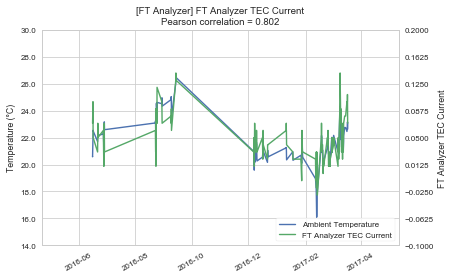

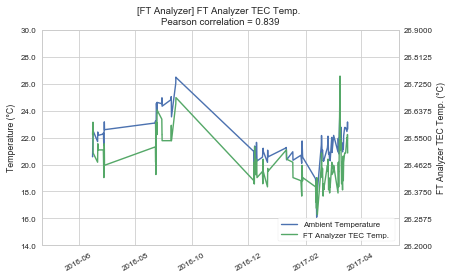

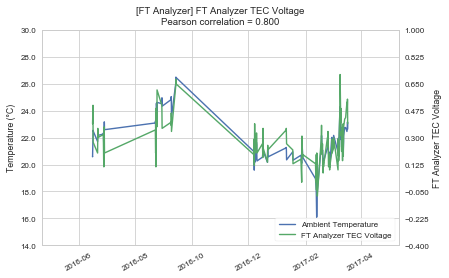

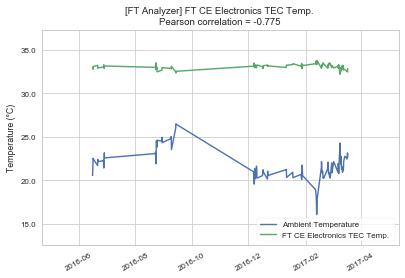

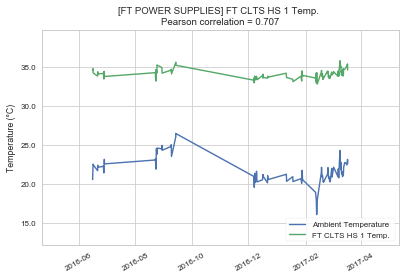

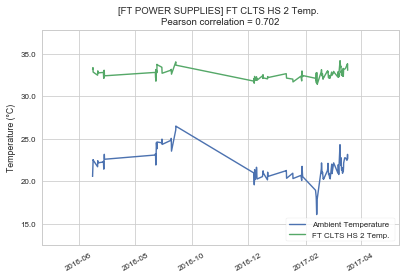

Analyzing Q-Exactive...


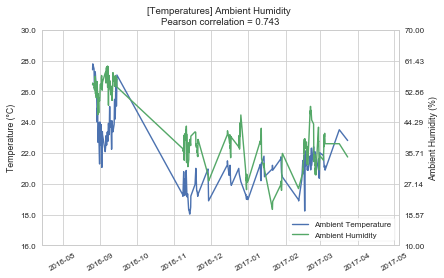

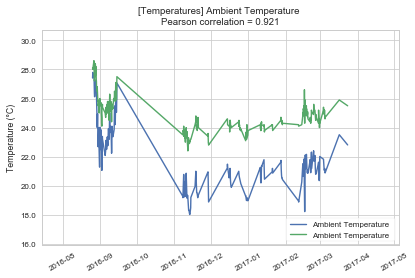

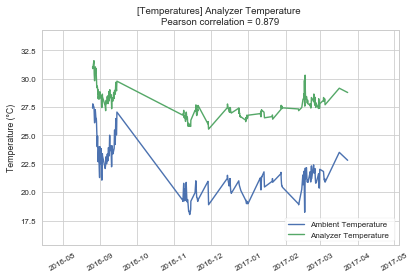

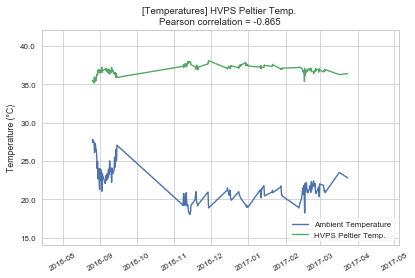

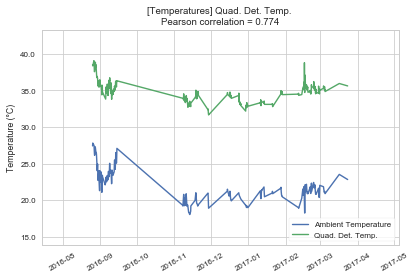

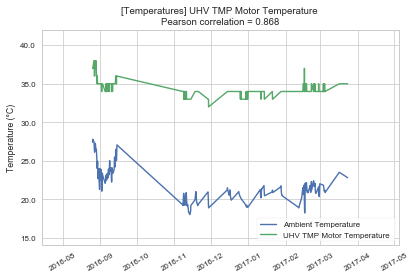

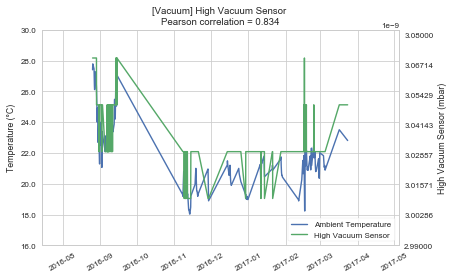

In [6]:
# analyze the relationship between instrument data (for multiple instruments) and the temperature data
instruments = ['Orbitrap', 'Q-Exactive']
for instrument in instruments:
    print(f'Analyzing {instrument}...')
    # read and preprocess the instrument metrics
    imon_metrics = pd.read_csv(f'../data/iMonDB_{instrument}.txt', sep='\t',
                               header=0, parse_dates={'Timestamp': [0]})

    # only use the 'median' instrument parameters
    imon_metrics_median = imon_metrics.filter(like='Median')

    # add timestamps rounded to the nearest quarter of an hour
    imon_metrics_median['Timestamp'] = pd.DatetimeIndex(imon_metrics['Timestamp']).round('15min')

    # merge the instrument metrics and temperature measurements
    metrics_temperature = pd.merge(imon_metrics_median, temperature,
                                   'inner', left_on='Timestamp', right_index=True)
    
    # check which metrics are correlated to the temperature
    min_corr = 0.7
    corr = metrics_temperature.corr('pearson')
    corr_temperature = corr['Temperature'].dropna().drop('Temperature')
    corr_temperature_filtered = corr_temperature[corr_temperature.abs() > min_corr].sort_index()
    
    for metric in corr_temperature_filtered.index:
        plot_temperature_vs_metric(metrics_temperature, metric, instrument)